# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import requests
import os
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from utils.text_gen import get_batch, train, validate, NLPDataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from attention.transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Sat Jun  3 17:29:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   51C    P8    29W / 370W |    466MiB / 10009MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_simple_dec_alice' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../../input', 'alice_short_story')
train_file = os.listdir(dataset_dir)
print(train_file)

['alice.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 1243 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 128
NUM_WORDS = 50304  # Vocabulary size.

# Batch size.
BATCH_SIZE = 1
VALID_SPLIT = 0.1
EPOCHS = 500

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### Tiktoken

In [10]:
enc = tiktoken.encoding_for_model("gpt2")

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths, enc)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([1536])
Number of unique tokens: 618


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 1383
Number of validation samples: 153


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

1383
153


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Model

In [18]:
model = Transformer(
    embed_dim=512, 
    src_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=8,
)

In [19]:
_ = model.to(device)

## Training

In [20]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (encoder): TransformerEncoder(
    (embedding): Embedding(
      (embed): Embedding(50304, 512)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [21]:
epochs = EPOCHS
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, 
        dataset_train, 
        optimizer, 
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    valid_epoch_loss = validate(
        model, 
        dataset_valid,  
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Training loss: {train_epoch_loss}")
    print(f"Validation loss: {valid_epoch_loss}")

    # Save model.
    torch.save(
        model, os.path.join(CHECKPOINT_DIR, 'model.pth')
    )
    print('-'*50)
#     if epoch + 1 <= 32:
#         scheduler.step()

[INFO]: Epoch 1 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 10.339359716935592
Validation loss: 9.276801586151123
--------------------------------------------------
[INFO]: Epoch 2 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 9.219327926635742
Validation loss: 8.805671691894531
--------------------------------------------------
[INFO]: Epoch 3 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 8.26830850947987
Validation loss: 8.131328582763672
--------------------------------------------------
[INFO]: Epoch 4 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 7.631755655462092
Validation loss: 7.68971586227417
--------------------------------------------------
[INFO]: Epoch 5 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.955135128714821
Validation loss: 7.30704140663147
--------------------------------------------------
[INFO]: Epoch 6 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.583670269359242
Validation loss: 7.122980117797852
--------------------------------------------------
[INFO]: Epoch 7 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 6.152407212690874
Validation loss: 6.977620840072632
--------------------------------------------------
[INFO]: Epoch 8 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.849177490581166
Validation loss: 6.906277894973755
--------------------------------------------------
[INFO]: Epoch 9 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.905214873227206
Validation loss: 6.917049169540405
--------------------------------------------------
[INFO]: Epoch 10 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.75372856313532
Validation loss: 6.854047536849976
--------------------------------------------------
[INFO]: Epoch 11 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.686879461461848
Validation loss: 6.9155542850494385
--------------------------------------------------
[INFO]: Epoch 12 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.66666824167425
Validation loss: 6.94969916343689
--------------------------------------------------
[INFO]: Epoch 13 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.548372312025591
Validation loss: 6.898918390274048
--------------------------------------------------
[INFO]: Epoch 14 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.522397041320801
Validation loss: 6.9376983642578125
--------------------------------------------------
[INFO]: Epoch 15 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.4128605669195
Validation loss: 6.960772514343262
--------------------------------------------------
[INFO]: Epoch 16 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.573689850893888
Validation loss: 6.92867112159729
--------------------------------------------------
[INFO]: Epoch 17 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.591140400279652
Validation loss: 6.950347185134888
--------------------------------------------------
[INFO]: Epoch 18 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.526132410222834
Validation loss: 7.034213066101074
--------------------------------------------------
[INFO]: Epoch 19 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.520438887856224
Validation loss: 7.071959018707275
--------------------------------------------------
[INFO]: Epoch 20 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.456472917036577
Validation loss: 6.975050449371338
--------------------------------------------------
[INFO]: Epoch 21 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.4510791084983135
Validation loss: 7.056494235992432
--------------------------------------------------
[INFO]: Epoch 22 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.589622454209761
Validation loss: 7.054578542709351
--------------------------------------------------
[INFO]: Epoch 23 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.441086985848167
Validation loss: 7.115562438964844
--------------------------------------------------
[INFO]: Epoch 24 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.485741181807085
Validation loss: 7.025544881820679
--------------------------------------------------
[INFO]: Epoch 25 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.442584644664418
Validation loss: 7.074748992919922
--------------------------------------------------
[INFO]: Epoch 26 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.461654099551114
Validation loss: 7.151542901992798
--------------------------------------------------
[INFO]: Epoch 27 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.461277831684459
Validation loss: 7.142233371734619
--------------------------------------------------
[INFO]: Epoch 28 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.443299770355225
Validation loss: 7.146574020385742
--------------------------------------------------
[INFO]: Epoch 29 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.445748719302091
Validation loss: 7.034922361373901
--------------------------------------------------
[INFO]: Epoch 30 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.406961657784202
Validation loss: 6.954427480697632
--------------------------------------------------
[INFO]: Epoch 31 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.253335519270464
Validation loss: 7.0739734172821045
--------------------------------------------------
[INFO]: Epoch 32 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.183672731572932
Validation loss: 7.056788921356201
--------------------------------------------------
[INFO]: Epoch 33 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.084359862587669
Validation loss: 6.969804525375366
--------------------------------------------------
[INFO]: Epoch 34 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.150004820390181
Validation loss: 7.021210432052612
--------------------------------------------------
[INFO]: Epoch 35 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.116056138818914
Validation loss: 6.9741082191467285
--------------------------------------------------
[INFO]: Epoch 36 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 5.038443435322154
Validation loss: 6.84347939491272
--------------------------------------------------
[INFO]: Epoch 37 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.99364016272805
Validation loss: 6.735641241073608
--------------------------------------------------
[INFO]: Epoch 38 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.879878694360906
Validation loss: 6.7111711502075195
--------------------------------------------------
[INFO]: Epoch 39 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.783524123105136
Validation loss: 6.740237236022949
--------------------------------------------------
[INFO]: Epoch 40 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.679158730940386
Validation loss: 6.804470062255859
--------------------------------------------------
[INFO]: Epoch 41 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.580643133683638
Validation loss: 6.882315158843994
--------------------------------------------------
[INFO]: Epoch 42 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.435925527052446
Validation loss: 6.7383692264556885
--------------------------------------------------
[INFO]: Epoch 43 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.341413541273638
Validation loss: 6.872700452804565
--------------------------------------------------
[INFO]: Epoch 44 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.310220805081454
Validation loss: 6.783868789672852
--------------------------------------------------
[INFO]: Epoch 45 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.444069905714556
Validation loss: 6.873780727386475
--------------------------------------------------
[INFO]: Epoch 46 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.33917533267628
Validation loss: 6.961029291152954
--------------------------------------------------
[INFO]: Epoch 47 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.003786520524458
Validation loss: 6.840504169464111
--------------------------------------------------
[INFO]: Epoch 48 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.183050784197721
Validation loss: 7.0496439933776855
--------------------------------------------------
[INFO]: Epoch 49 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.184012109583074
Validation loss: 6.91402530670166
--------------------------------------------------
[INFO]: Epoch 50 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.181919986551458
Validation loss: 6.936662435531616
--------------------------------------------------
[INFO]: Epoch 51 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.915771159258756
Validation loss: 7.022548198699951
--------------------------------------------------
[INFO]: Epoch 52 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.7379204576665703
Validation loss: 6.9776530265808105
--------------------------------------------------
[INFO]: Epoch 53 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 4.035430843179876
Validation loss: 7.053757667541504
--------------------------------------------------
[INFO]: Epoch 54 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.680660269477151
Validation loss: 7.045202732086182
--------------------------------------------------
[INFO]: Epoch 55 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.569841276515614
Validation loss: 7.089618921279907
--------------------------------------------------
[INFO]: Epoch 56 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.6469406214627353
Validation loss: 6.9999964237213135
--------------------------------------------------
[INFO]: Epoch 57 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.7053459124131636
Validation loss: 6.867834091186523
--------------------------------------------------
[INFO]: Epoch 58 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.432008678262884
Validation loss: 7.135364055633545
--------------------------------------------------
[INFO]: Epoch 59 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.4316332123496314
Validation loss: 7.218528747558594
--------------------------------------------------
[INFO]: Epoch 60 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.385865428230979
Validation loss: 7.150827407836914
--------------------------------------------------
[INFO]: Epoch 61 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.433455987410112
Validation loss: 6.9926347732543945
--------------------------------------------------
[INFO]: Epoch 62 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.229139067909934
Validation loss: 7.150898456573486
--------------------------------------------------
[INFO]: Epoch 63 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.214390993118286
Validation loss: 7.054152250289917
--------------------------------------------------
[INFO]: Epoch 64 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.3153051896528765
Validation loss: 7.179872989654541
--------------------------------------------------
[INFO]: Epoch 65 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.2667203816500576
Validation loss: 7.332023859024048
--------------------------------------------------
[INFO]: Epoch 66 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.134805202484131
Validation loss: 7.198217391967773
--------------------------------------------------
[INFO]: Epoch 67 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.093626867641102
Validation loss: 7.139983892440796
--------------------------------------------------
[INFO]: Epoch 68 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.051316022872925
Validation loss: 7.118135929107666
--------------------------------------------------
[INFO]: Epoch 69 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.1167325756766577
Validation loss: 7.125636339187622
--------------------------------------------------
[INFO]: Epoch 70 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.958534435792403
Validation loss: 7.086241960525513
--------------------------------------------------
[INFO]: Epoch 71 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 3.0050003311850806
Validation loss: 7.131134033203125
--------------------------------------------------
[INFO]: Epoch 72 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.9510888186368076
Validation loss: 7.398070335388184
--------------------------------------------------
[INFO]: Epoch 73 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.847115321592851
Validation loss: 7.2043633460998535
--------------------------------------------------
[INFO]: Epoch 74 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8461496613242407
Validation loss: 7.2877748012542725
--------------------------------------------------
[INFO]: Epoch 75 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8906222690235484
Validation loss: 7.1075592041015625
--------------------------------------------------
[INFO]: Epoch 76 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.7981602278622715
Validation loss: 7.236420154571533
--------------------------------------------------
[INFO]: Epoch 77 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.6319067911668257
Validation loss: 7.214127063751221
--------------------------------------------------
[INFO]: Epoch 78 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8943700140172783
Validation loss: 7.258968830108643
--------------------------------------------------
[INFO]: Epoch 79 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8508155129172583
Validation loss: 7.348029136657715
--------------------------------------------------
[INFO]: Epoch 80 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.6470571864734995
Validation loss: 7.296682357788086
--------------------------------------------------
[INFO]: Epoch 81 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.68568095293912
Validation loss: 7.413150787353516
--------------------------------------------------
[INFO]: Epoch 82 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.8182660016146572
Validation loss: 7.250726222991943
--------------------------------------------------
[INFO]: Epoch 83 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5006721886721524
Validation loss: 7.372026443481445
--------------------------------------------------
[INFO]: Epoch 84 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5517806790091773
Validation loss: 7.443665981292725
--------------------------------------------------
[INFO]: Epoch 85 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.44717153635892
Validation loss: 7.601008653640747
--------------------------------------------------
[INFO]: Epoch 86 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.415408806367354
Validation loss: 7.526374101638794
--------------------------------------------------
[INFO]: Epoch 87 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5171784270893443
Validation loss: 7.557212591171265
--------------------------------------------------
[INFO]: Epoch 88 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.5478728901256216
Validation loss: 7.607512950897217
--------------------------------------------------
[INFO]: Epoch 89 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.41504768891768
Validation loss: 7.277519941329956
--------------------------------------------------
[INFO]: Epoch 90 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.4860710447484795
Validation loss: 7.526880979537964
--------------------------------------------------
[INFO]: Epoch 91 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3652699427171187
Validation loss: 7.413814306259155
--------------------------------------------------
[INFO]: Epoch 92 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3505596030842173
Validation loss: 7.441765069961548
--------------------------------------------------
[INFO]: Epoch 93 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.352008591998707
Validation loss: 7.60119104385376
--------------------------------------------------
[INFO]: Epoch 94 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3219126246192237
Validation loss: 7.4616453647613525
--------------------------------------------------
[INFO]: Epoch 95 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.334802280772816
Validation loss: 7.593673467636108
--------------------------------------------------
[INFO]: Epoch 96 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.225407990542325
Validation loss: 7.652838468551636
--------------------------------------------------
[INFO]: Epoch 97 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3217987797477027
Validation loss: 7.584696531295776
--------------------------------------------------
[INFO]: Epoch 98 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.219711726362055
Validation loss: 7.729435205459595
--------------------------------------------------
[INFO]: Epoch 99 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.3715027895840732
Validation loss: 7.662173271179199
--------------------------------------------------
[INFO]: Epoch 100 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.407971815629439
Validation loss: 7.655587673187256
--------------------------------------------------
[INFO]: Epoch 101 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0965371131896973
Validation loss: 7.6131062507629395
--------------------------------------------------
[INFO]: Epoch 102 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.290183099833402
Validation loss: 7.539227485656738
--------------------------------------------------
[INFO]: Epoch 103 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.080594615502791
Validation loss: 7.466253280639648
--------------------------------------------------
[INFO]: Epoch 104 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.2988106554204766
Validation loss: 7.833257436752319
--------------------------------------------------
[INFO]: Epoch 105 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0736426331780176
Validation loss: 7.498922348022461
--------------------------------------------------
[INFO]: Epoch 106 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.108923402699557
Validation loss: 7.491495132446289
--------------------------------------------------
[INFO]: Epoch 107 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9972180886702104
Validation loss: 7.55618691444397
--------------------------------------------------
[INFO]: Epoch 108 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9773728522387417
Validation loss: 7.569157123565674
--------------------------------------------------
[INFO]: Epoch 109 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.12177020853216
Validation loss: 7.731167554855347
--------------------------------------------------
[INFO]: Epoch 110 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9083522883328525
Validation loss: 7.5612781047821045
--------------------------------------------------
[INFO]: Epoch 111 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9287694909355857
Validation loss: 7.710312366485596
--------------------------------------------------
[INFO]: Epoch 112 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0013011260466143
Validation loss: 7.8884711265563965
--------------------------------------------------
[INFO]: Epoch 113 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.0050840811295942
Validation loss: 7.729679584503174
--------------------------------------------------
[INFO]: Epoch 114 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8885560144077649
Validation loss: 7.77492094039917
--------------------------------------------------
[INFO]: Epoch 115 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9137760292400012
Validation loss: 7.729334115982056
--------------------------------------------------
[INFO]: Epoch 116 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.872267397967252
Validation loss: 7.662781715393066
--------------------------------------------------
[INFO]: Epoch 117 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 2.1458527499979194
Validation loss: 8.009370803833008
--------------------------------------------------
[INFO]: Epoch 118 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8447764028202405
Validation loss: 7.707738161087036
--------------------------------------------------
[INFO]: Epoch 119 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7767745798284358
Validation loss: 7.785337924957275
--------------------------------------------------
[INFO]: Epoch 120 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9080655683170666
Validation loss: 7.650782585144043
--------------------------------------------------
[INFO]: Epoch 121 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9642427617853337
Validation loss: 7.886552333831787
--------------------------------------------------
[INFO]: Epoch 122 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7680360187183728
Validation loss: 7.948935031890869
--------------------------------------------------
[INFO]: Epoch 123 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8924958597530017
Validation loss: 8.022018432617188
--------------------------------------------------
[INFO]: Epoch 124 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8287927129051902
Validation loss: 8.063680171966553
--------------------------------------------------
[INFO]: Epoch 125 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8173146031119607
Validation loss: 7.89141845703125
--------------------------------------------------
[INFO]: Epoch 126 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9827965606342663
Validation loss: 7.870834827423096
--------------------------------------------------
[INFO]: Epoch 127 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7091468355872415
Validation loss: 7.956735372543335
--------------------------------------------------
[INFO]: Epoch 128 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.8983767466111616
Validation loss: 8.071740627288818
--------------------------------------------------
[INFO]: Epoch 129 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7352628924629905
Validation loss: 8.083097457885742
--------------------------------------------------
[INFO]: Epoch 130 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7014328999952837
Validation loss: 8.220951080322266
--------------------------------------------------
[INFO]: Epoch 131 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9195043282075361
Validation loss: 7.917407512664795
--------------------------------------------------
[INFO]: Epoch 132 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7072428031401201
Validation loss: 7.975500583648682
--------------------------------------------------
[INFO]: Epoch 133 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7040881460363215
Validation loss: 8.217614650726318
--------------------------------------------------
[INFO]: Epoch 134 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.744243480942466
Validation loss: 7.9991536140441895
--------------------------------------------------
[INFO]: Epoch 135 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5980755740945989
Validation loss: 8.230927467346191
--------------------------------------------------
[INFO]: Epoch 136 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6918247721411965
Validation loss: 8.199524879455566
--------------------------------------------------
[INFO]: Epoch 137 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7480499310926958
Validation loss: 8.078903913497925
--------------------------------------------------
[INFO]: Epoch 138 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5574695088646628
Validation loss: 7.859687089920044
--------------------------------------------------
[INFO]: Epoch 139 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5900238210504705
Validation loss: 8.094522953033447
--------------------------------------------------
[INFO]: Epoch 140 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.7157716751098633
Validation loss: 8.211441040039062
--------------------------------------------------
[INFO]: Epoch 141 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6407505165446887
Validation loss: 8.000535011291504
--------------------------------------------------
[INFO]: Epoch 142 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6887841658158735
Validation loss: 8.094161987304688
--------------------------------------------------
[INFO]: Epoch 143 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5678074143149636
Validation loss: 8.124037265777588
--------------------------------------------------
[INFO]: Epoch 144 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6075041510842063
Validation loss: 8.141622543334961
--------------------------------------------------
[INFO]: Epoch 145 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4994080933657559
Validation loss: 8.02337121963501
--------------------------------------------------
[INFO]: Epoch 146 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.6337071006948298
Validation loss: 8.314422607421875
--------------------------------------------------
[INFO]: Epoch 147 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.690222978591919
Validation loss: 8.196256160736084
--------------------------------------------------
[INFO]: Epoch 148 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5195521766489202
Validation loss: 7.8003950119018555
--------------------------------------------------
[INFO]: Epoch 149 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.9668339599262585
Validation loss: 7.9531378746032715
--------------------------------------------------
[INFO]: Epoch 150 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.572731451554732
Validation loss: 8.050718307495117
--------------------------------------------------
[INFO]: Epoch 151 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.560135082765059
Validation loss: 8.206115245819092
--------------------------------------------------
[INFO]: Epoch 152 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4658825505863537
Validation loss: 8.046353816986084
--------------------------------------------------
[INFO]: Epoch 153 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5484760024330833
Validation loss: 8.083202838897705
--------------------------------------------------
[INFO]: Epoch 154 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.592173543843356
Validation loss: 8.203779697418213
--------------------------------------------------
[INFO]: Epoch 155 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.715432806448503
Validation loss: 8.30238962173462
--------------------------------------------------
[INFO]: Epoch 156 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.461578607559204
Validation loss: 8.1410813331604
--------------------------------------------------
[INFO]: Epoch 157 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4438062797893176
Validation loss: 8.228553295135498
--------------------------------------------------
[INFO]: Epoch 158 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5337632786143909
Validation loss: 8.216918468475342
--------------------------------------------------
[INFO]: Epoch 159 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5862946510314941
Validation loss: 8.049782276153564
--------------------------------------------------
[INFO]: Epoch 160 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5755535580895164
Validation loss: 8.231510639190674
--------------------------------------------------
[INFO]: Epoch 161 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3640233928507024
Validation loss: 8.340096950531006
--------------------------------------------------
[INFO]: Epoch 162 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.617077274755998
Validation loss: 8.339096546173096
--------------------------------------------------
[INFO]: Epoch 163 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3751476027748801
Validation loss: 8.208601474761963
--------------------------------------------------
[INFO]: Epoch 164 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3840272318233142
Validation loss: 8.30870771408081
--------------------------------------------------
[INFO]: Epoch 165 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.566350362517617
Validation loss: 8.077543258666992
--------------------------------------------------
[INFO]: Epoch 166 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.462345535104925
Validation loss: 8.208903312683105
--------------------------------------------------
[INFO]: Epoch 167 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4015522870150479
Validation loss: 7.979779958724976
--------------------------------------------------
[INFO]: Epoch 168 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.5621534802696921
Validation loss: 8.269334316253662
--------------------------------------------------
[INFO]: Epoch 169 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4204105897383257
Validation loss: 8.543947696685791
--------------------------------------------------
[INFO]: Epoch 170 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.358508055860346
Validation loss: 8.635696411132812
--------------------------------------------------
[INFO]: Epoch 171 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.39692269672047
Validation loss: 8.279838562011719
--------------------------------------------------
[INFO]: Epoch 172 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4817532300949097
Validation loss: 8.162604808807373
--------------------------------------------------
[INFO]: Epoch 173 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3448152433742175
Validation loss: 8.430357456207275
--------------------------------------------------
[INFO]: Epoch 174 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4738629406148738
Validation loss: 8.419118881225586
--------------------------------------------------
[INFO]: Epoch 175 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4076650034297595
Validation loss: 8.204660415649414
--------------------------------------------------
[INFO]: Epoch 176 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3087575218894265
Validation loss: 8.235883712768555
--------------------------------------------------
[INFO]: Epoch 177 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3510783910751343
Validation loss: 8.39795207977295
--------------------------------------------------
[INFO]: Epoch 178 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3225621743635698
Validation loss: 8.410776138305664
--------------------------------------------------
[INFO]: Epoch 179 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3084110888567837
Validation loss: 8.492518901824951
--------------------------------------------------
[INFO]: Epoch 180 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3312408924102783
Validation loss: 8.520792961120605
--------------------------------------------------
[INFO]: Epoch 181 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3362209580161355
Validation loss: 8.729347229003906
--------------------------------------------------
[INFO]: Epoch 182 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3700646487149326
Validation loss: 8.542051792144775
--------------------------------------------------
[INFO]: Epoch 183 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2979828336022117
Validation loss: 8.46610975265503
--------------------------------------------------
[INFO]: Epoch 184 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2855146473104304
Validation loss: 8.805283546447754
--------------------------------------------------
[INFO]: Epoch 185 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3004799105904319
Validation loss: 8.533761978149414
--------------------------------------------------
[INFO]: Epoch 186 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3199350833892822
Validation loss: 8.571594715118408
--------------------------------------------------
[INFO]: Epoch 187 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2872199687090786
Validation loss: 8.72596263885498
--------------------------------------------------
[INFO]: Epoch 188 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.252114241773432
Validation loss: 8.499207019805908
--------------------------------------------------
[INFO]: Epoch 189 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3733914440328425
Validation loss: 8.534218311309814
--------------------------------------------------
[INFO]: Epoch 190 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.168080123988065
Validation loss: 8.53395128250122
--------------------------------------------------
[INFO]: Epoch 191 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2252721353010698
Validation loss: 7.925466060638428
--------------------------------------------------
[INFO]: Epoch 192 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.356275352564725
Validation loss: 8.508866310119629
--------------------------------------------------
[INFO]: Epoch 193 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3271714448928833
Validation loss: 8.700087070465088
--------------------------------------------------
[INFO]: Epoch 194 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.3009296547282825
Validation loss: 8.70415210723877
--------------------------------------------------
[INFO]: Epoch 195 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.2930343584580855
Validation loss: 8.698850631713867
--------------------------------------------------
[INFO]: Epoch 196 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.246400605548512
Validation loss: 8.451708316802979
--------------------------------------------------
[INFO]: Epoch 197 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.319891171021895
Validation loss: 8.625388145446777
--------------------------------------------------
[INFO]: Epoch 198 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.4194709062576294
Validation loss: 8.582780838012695
--------------------------------------------------
[INFO]: Epoch 199 of 500
Training


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Training loss: 1.263043457811529
Validation loss: 8.464036464691162


RuntimeError: [enforce fail at inline_container.cc:300] . unexpected pos 160368832 vs 160368720

In [22]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

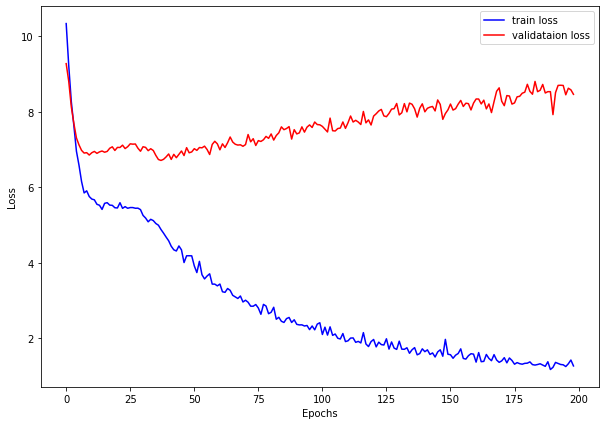

In [23]:
save_plots(train_acc, valid_acc, train_loss, valid_loss)

## Test Model

In [24]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [25]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [ ]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [ ]:
enc = tiktoken.encoding_for_model("gpt2")

In [ ]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions.squeeze(0)[-1, :] / temperature
    predictions = predictions.exp().cpu()
    next_token = torch.multinomial(predictions, num_samples=1)
    return int(next_token[0].cpu())
    

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    num_tokens = len(sentence)
    for temeperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temeperature}")
        for i in range(generate_length):
            int_vector = return_int_vector(enc, sample)
            input_tensor = torch.tensor(int_vector, dtype=torch.int32)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions)
#             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
            sample += ' ' + enc.decode([next_token])
        print(sample)
        print('\n')

In [ ]:
generate_length = 128

In [ ]:
sentences = [
    "Alice was a curious and imaginative young girl who lived in a quiet village."
]

In [ ]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')